Adaboost boosts a set of weak learners to a strong learner, through initially setting uniform weights on all the records, and increasing said weights on all records that have been wrongly classified, whereas correctly classified instances see their weights decreased, and will thus be less likely to be sampled.

In [1]:
# import libraries
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
# import datasets
X_train = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [3]:
# parameter grid to search
param_grid = {
    'n_estimators' : [100, 400],
    'learning_rate' : [1.0, 2.0],
}

# classifier
rf = AdaBoostClassifier(random_state=42, estimator= DecisionTreeClassifier(max_depth=1))
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel()) 

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: {:.4f}".format(grid_search.best_score_))

Best Parameters:  {'learning_rate': 1.0, 'n_estimators': 400}
Best AUC: 0.8795


In [4]:
adaboost = grid_search.best_estimator_ # select best estimator based on best parameters

# refit model on training set
adaboost.fit(X = X_train, y = y_train.values.ravel())

# predict on the training set
y_pred_train = adaboost.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# AUC on training set
y_probs_train = adaboost.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_test = adaboost.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# AUC on test set
y_probs_test = adaboost.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8620
AUC on training set is 0.8816510122934644
Accuracy on test set: 0.8627
AUC on test set is 0.8808602759971511


In [5]:
# confusion matrix
classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='RdPu', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

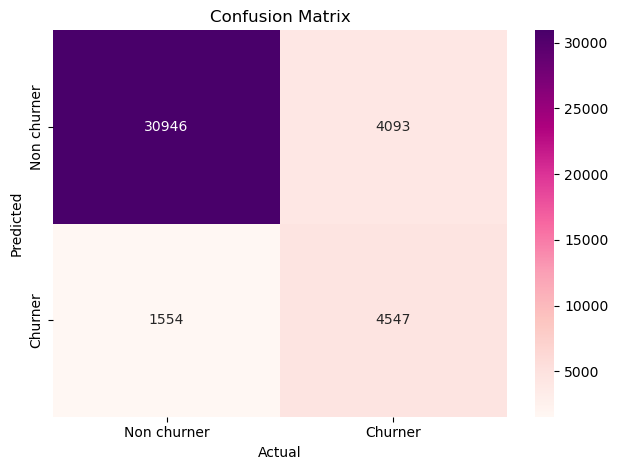

In [6]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_test,y_test)

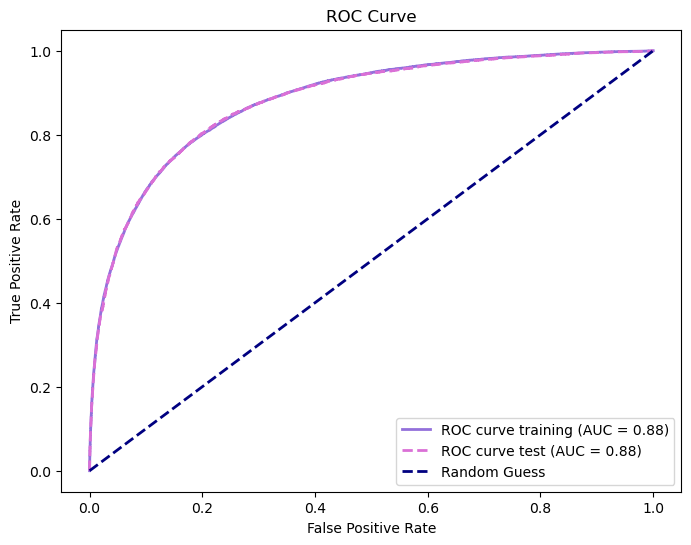

In [7]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='mediumpurple', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'orchid', linestyle='--', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test = precision_score(y_test, y_pred_test)
# recall
recall_test = recall_score(y_test, y_pred_test)
# f1-measure
f1_test = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test))
print('Recall on the test set is {}'.format(recall_test))
print('f1-measure on the test set is {}'.format(f1_test))

Precision on the test set is 0.7452876577610228
Recall on the test set is 0.5262731481481482
f1-measure on the test set is 0.6169187979105895


In [9]:
import pickle

# save model
model_name='adaboost.pkl'
model_file=open(model_name,'wb')
pickle.dump(adaboost, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)